# DL-Guided Cross-Species Gene Sequence Optimization (a VERY NAIVE demo)

**This is essentially just an extremely naive demo I played around with before starting uni to get familiarised with the field.**

---

> *In-silico horizontal gene transfer*

![align1](./img/align_pr1.png)

The project was initially developed as the dry-lab component of my iGEM team’s synthetic biology project. While entirely illustrative in nature (and independent of our wet-lab experiments, where plasmids for actual biotransformation are transferred across two bacterial species), the primary aim is to deepen my understanding of computational biology. I personally find the field extremely fascinating, and over the past few weeks, the whole process of designing the pipeline, researching algorithms, and implementing (plus so much debugging...) the code has been both rewarding and incredibly fun.

The central idea behind the pipeline is that the base model (in this case [Evo-1](https://github.com/evo-design/evo/)) captures general *prokaryotic* genomic patterns, while fine-tuning on the target host species' DNA corpus enables it to learn host-specific contextual information. This, in turn, helps reveal how 'host-like' a candidate sequence is, thereby guiding sequence optimization. This 'mutagenesis' step is carried out via an iterative, directed-evolution–like MH-MCMC sampling procedure, which recursively proposes point mutations on the current sequence while protecting the enzyme's active site from non-synonymous substitutions. Finally, optimized sequences are evaluated by calculating CAI and GC content to assess host compatibility, and by performing structural predictions to visualize the structures of the new proteins (via PyMol) and compute further metrics (pLDDTs and scores for alignment with reference sequence).

(Regarding the 'gradient-based sensitivity analysis' step, I also ran a demo with [Nucleotide Transformer](https://github.com/instadeepai/nucleotide-transformer), another DNA (masked) LM yet not at single-nt resolution and not trained specifically on prokaryotic genomes.)

More details on the pipeline can be found within the notebook cells.


In [1]:
# Section 1: preparation


!pip install --upgrade evo-model biopython transformers accelerate datasets peft > /dev/null 2>&1
print('Successfully installed!')

from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForCausalLM,
    DataCollatorForLanguageModeling, Trainer, TrainingArguments, BitsAndBytesConfig
)
from datasets import Dataset
from peft import LoraConfig, get_peft_model, TaskType
from Bio import SeqIO
from Bio.Seq import Seq
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import zipfile
import random
import tqdm
import os

# We use Evo-1 as the base model, with the checkpoint 'for molecular-scale finetuning tasks' (the other one pretrained with 131,072 context is said to be for tasks 'at the genome scale')
print('Evo-1 is a DNA language model (more specifically, a GPT-styled causal LM that can be used for generation and scoring tasks based on log-likelihood of the next token) trained on **prokaryotic** whole-genome sequences at a single-nucleotide, byte-level resolution.')
model_name = 'togethercomputer/evo-1-8k-base'

def set_seed(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

Evo-1 is a DNA language model (more specifically, a GPT-styled causal LM that can be used for generation and scoring tasks based on log-likelihood of the next token) trained on **prokaryotic** whole-genome sequences at a single-nucleotide, byte-level resolution.


In [2]:
# Section 2: dataset creation for fine-tuning


# Install NCBI Datasets CLI (documentation: https://www.ncbi.nlm.nih.gov/datasets/docs/v2/)
!curl -o datasets 'https://ftp.ncbi.nlm.nih.gov/pub/datasets/command-line/v2/linux-amd64/datasets'
!chmod +x datasets

# Download host genome by NCBI Assembly accession
accession = 'GCF_000739105.1'  # RefSeq; our target host species: Streptomyces lividans TK24
# GenBank FlatFile (.gbff) includes genomic sequence and annotations for the following CDS extraction!
!./datasets download genome accession {accession} --include gbff --filename genome.zip > /dev/null 2>&1
print('Genome downloaded!!')

# Unzip and locate .gbff file
with zipfile.ZipFile('genome.zip', 'r') as zip_ref:
    zip_ref.extractall('genome_data')
gbff_path = None
for root, _, files in os.walk('genome_data'):
    for file in files:
        if file.endswith('.gbff'):
            gbff_path = os.path.join(root, file)
            break
print(f'Found .gbff file:, {gbff_path}!')

cds_sequences = []
for record in SeqIO.parse(gbff_path, "genbank"):
    for feature in record.features:
        if feature.type == "CDS":
            cds_seq = feature.location.extract(record).seq
            cds_sequences.append({"sequence": str(cds_seq).upper()})
print(f'Extracted {len(cds_sequences)} coding DNA sequences!')
print(cds_sequences[:3])

# Create HuggingFace Dataset
dataset = Dataset.from_list(cds_sequences)
# Split the dataset
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
print('Dataset created:')
print(split_dataset)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  12.9M      0  0:00:01  0:00:01 --:--:-- 12.9M
Genome downloaded!!
Found .gbff file:, genome_data/ncbi_dataset/data/GCF_000739105.1/genomic.gbff!
Extracted 7474 coding DNA sequences!
[{'sequence': 'ATGGCACCGAAGACCGAACGCATCCAGTTCCTGCGGGCCGTGCGGCAGCTGCGCCGGATCCGCTCCTTCTACGCTGCGGCCGTTCTGCTGTGGACGGGGAGCACTGCCTGGACGGGTTGGCAGGCTCCGGGGAGCCGGCAGATGTGGGTGTCCGTTCTCCTCCTGGCCGTCTTCGCCGTACTGCTCGTCACCGCGAGCCTCGCCCTGCGGCGTCTCGCCGTTCCCGCAACGGGCCGGCCCGTGCACCACGCTGCCCCGCACAAGCTGCCGAGCATCCGTCGTCACGCTCACGCCTGA'}, {'sequence': 'GTGGAGATCAGTGAGTACGAGACCCTCTCCATACTCCTGGATGCTGAGGCGGATCCGAACGAGGTGTGCTTCGGGCTCACGTTGCTGACCCAGCGGCTGCTCCAGCGCTTCCTCACCCTCACCCCGGCCAAATCCGCAGGGAGCGCGCGTGACGAATGA'}, {'sequence': 'GTGACGAATGATCACGGGCCGTCGCCCCTCGGCTCGGGCTCCCCTTACAGCGACGCCTCGATCTACGTGGACGCGGAGGCCGCCCCGCGGATCATGGCCCGGCTTCGAGACGCCCTCGGC

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: ', device)

# Load pretrained base model
model_config = AutoConfig.from_pretrained(model_name, trust_remote_code=True, revision="1.1_fix")
model_config.use_cache = False
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    config=model_config,
    trust_remote_code=True,
    revision="1.1_fix",
    device_map='auto',
    torch_dtype=torch.float16)

Device:  cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_hyena.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- configuration_hyena.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_hyena.py: 0.00B [00:00, ?B/s]

engine.py: 0.00B [00:00, ?B/s]

utils.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- utils.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- engine.py
- utils.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


layers.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- layers.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.py: 0.00B [00:00, ?B/s]

positional_embeddings.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- positional_embeddings.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


cache.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- cache.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- tokenizer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- model.py
- positional_embeddings.py
- cache.py
- tokenizer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/togethercomputer/evo-1-131k-base:
- modeling_hyena.py
- engine.py
- layers.py
- model.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [4]:
# Section 3: LoRA fine-tuning of Evo-1
# Only training a small proportion of parameters due to limited computational power...


# Tokenize
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
print("Tokenizing 'ATCGATCG'...")
test_tokenize = tokenizer.encode('ATCGATCG', return_tensors='pt')
print(f'Resulted token IDs (Evo is at single-nt resolution): {test_tokenize}') # [batch_size, n_tokens]

tokenizer.pad_token = 'X'
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
def tokenize(example):  # always OOM... `max_length` set to super small now
    return tokenizer(example['sequence'], max_length=512, padding="longest", truncation=True)
tokenized_dataset = split_dataset.map(tokenize,remove_columns=['sequence'])
tokenized_dataset.set_format(type='torch')
print('Tokenized dataset:\n', tokenized_dataset)

# Apply LoRA
lora_config = LoraConfig(
    task_type=None, # otherwise throws error since it would insert kwarg 'inputs_embeds' into the model's forward() method...
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias='none',
    target_modules='all-linear')
lora_model = get_peft_model(model, lora_config)
lora_model.print_trainable_parameters()

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=1e-4,
    save_total_limit=2,
    bf16=True
)
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator
)
print('Training...')
trainer.train()
print('Training completed!!!')

# Save model
lora_model.save_pretrained("./fine_tuned_evo")
tokenizer.save_pretrained("./fine_tuned_evo")

# Evaluate
eval = trainer.evaluate()
perplexity = math.exp(eval['eval_loss'])
print(f'Perplexity after fine-tuning: {perplexity:.4f}')

with torch.no_grad():
    test_loss = tokenizer('ATCGATCG', return_tensors='pt').input_ids.to(device)
    loss = lora_model(test_loss, labels=test_loss).loss
print("Fine-tuned model negative log-likelihood for 'ATCGATCG': ", loss.item())
print(f'Likelihood: {math.exp(-loss.item()):.4f}%')


tokenizer_config.json:   0%|          | 0.00/299 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Tokenizing 'ATCGATCG'...
Resulted token IDs (Evo is at single-nt resolution): tensor([[65, 84, 67, 71, 65, 84, 67, 71]])


Map:   0%|          | 0/6726 [00:00<?, ? examples/s]

Map:   0%|          | 0/748 [00:00<?, ? examples/s]

Tokenized dataset:
 DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6726
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 748
    })
})
trainable params: 17,829,888 || all params: 6,470,610,944 || trainable%: 0.2756
Training...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kiara725 (kiara725-university-of-oxford) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.565500
1000,0.551000
1500,0.545900
2000,0.524400
2500,0.509200


Step,Training Loss
500,0.565500
1000,0.551000
1500,0.545900
2000,0.524400
2500,0.509200
3000,0.491200


Training completed!!!


Perplexity after fine-tuning: 1.8105
Fine-tuned model negative log-likelihood for 'ATCGATCG':  1.8316192626953125
Likelihood: 0.1602%


## The search for a better sequence...

Trying to balance exploration and exploitation, and avoid enumerating by brute force...

**Gradient-based sensitivity analysis**: by calculating the gradient of the model's loss w.r.t. each position on the current sequence, we can identify the nucleotides *where* mutations would most significantly impact the 'host-likeness' score (a small nudge can lead to greater changes). Rather than mutating positions randomly..., we leverage the model's knowledge to guide the search!

(*Note that this idea isn't applicable with Evo-1 since its StripedHyena architecture doesn't support `inputs_embeds` *(input embeddings are needed since gradients can only flow through continuous tensors rather than discrete ids)* as a kwarg in the `forward()` method... Tried a few workarounds but didn't work as well (so sad). However, a demo of running this check via [Nucleotide Transformer](https://github.com/instadeepai/nucleotide-transformer) (which does support that kwarg; however, due to its way of tokenization, the performance for the check is very poor there...) can be seen directly below. For Evo-1, we'll just randomly propose positions to mutate...*)


**Constrained MH-MCMC sampling**: once we've identified which positions to randomly mutate (*Monte Carlo*), we score the mutated sequence and use Metropolis criterion to decide whether to accept the mutation, and the iteration goes on autoregressively (*a Markov chain*). For those occurring in predefined regions (particularly the enzyme's active site), the new codon must be synonymous to be accepted. Codons that are swapped to stop codons are also automatically rejected.

---

References:
- [1] https://github.com/arjan-hada/protein-variant-prediction/
- [2] https://nrel.github.io/EvoProtGrad/getting_started/MCMC/

In [8]:
# Test the feasibility of the idea with Nucleotide Transformer, which does allow us to run backprop w.r.t. input embeddings
!pip install --upgrade git+https://github.com/huggingface/transformers.git > /dev/null 2>&1
from transformers import AutoModelForMaskedLM
tokenizer2 = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-50m-multi-species", trust_remote_code=True)
model2 = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-50m-multi-species", trust_remote_code=True)
model2.to("cuda" if torch.cuda.is_available() else "cpu")
def compute_sensitivity(sequence, model, tokenizer, top_k):
    print(f'Initial sequence length: {len(sequence)}bp')
    model.eval()
    torch.set_grad_enabled(True)
    input_ids = tokenizer.encode(sequence, return_tensors='pt').to(model.device)
    print(f'Number of tokens after tokenization (unlike Evo, Nucleotide Transformer is not tokenized per nt (6)): {input_ids.shape[1]}') # [batch_size, n_tokens]
    embeds = model.get_input_embeddings()(input_ids)  # **continuous** tensor for gradients to flow through
    print(f'Input embeddings: {embeds}\nShape of embeddings: {embeds.shape}\t[batch_size, n_tokens, dim]')
    embeds.retain_grad()
    model.zero_grad()
    outputs = model(inputs_embeds=embeds, labels=input_ids)
    loss = outputs.loss
    loss.backward()
    grads = embeds.grad
    print(f'Gradients wrt token embeddings: {grads}\nShape: {grads.shape}')
    norm = grads.norm(dim=-1).squeeze(0)
    print(f'\nCompute magnitudes of gradients wrt each token -> {norm.shape}')
    top_pos = torch.topk(norm, top_k).indices # top-k instead of greedy search (choosing the largest position only) to be more exploratory
    print(f'Indices of most sensitive tokens: {top_pos.cpu().numpy()}')
    return top_pos.cpu().numpy()
top_k = 3
# Wild-type alkB sequence from original host species (Rhodococcus erythropolis strain XP; sequence extracted from NCBI)
initial_seq = 'GTGTCGACGCACGTGAACTCGCAGTCCGGGCAGACACTCCCGCCCGAGCAGTGGCGTGACAAGAAGAGATATCTTTGGCTGCTCGGCCTGGTGCCGCCGACGGCGGTCTTCATTGCCGTCGGATTGGTCGCGTTGTTCAACAGTCTCGGGTGGAACGCGGTCTCGCCGGTGTGGTGGTGGATCGGGCCGTTGCTCGTCTACATCCTGCTCCCGATCCTCGACATCTTCTTCGGTCCGGACGGCGAGAATCCGCCGGACGAGGTGATGGAGCGCCTCGAGAACGACAAGTACTACCGGTACTGCACCTACATCTACATACCGTTCCAGTTGGCCAGCCTGGTCCTGGCCTGCTATCTCTGGTCGGCGACCGACCTGTCCTGGCTCGGAATCGACGGGGGACTGGGGCTGATCTCCAAGATCGGTCTGGCGATCAGTATCGGTTGCGTCGCAGGAATCGGGATCAACACCGCACACGAACTAGGTCACAAGAAGGACGATCTCGAGCGCTGGTTGTCGAAGATCACTCTGGCGCAGTCGTTTTACGGCCACTTCTACATCGAGCACAATCGTGGACACCACGTGCGGGTCGCCACGCCCGAGGATCCGGCGTCGTCTCGCTTCGGCGAGAGCTTCTGGACCTTCCTGCCGCGCAGTGTGTGGGGATCTCTGCGCTCGTCGTGGTCCCTGGAGAAAGCCAGGCTCGATCGACTGGGTAAGAAGCCGTGGACAATTCGCAACGACGTCCTGCATTCGTGGTTGATGTCCGTCGTACTCTTCGGTGTCCTCGTCGCCGTTTTCGGGCTCTCGGTGCTGCCGTTCCTGGTGCTGCAGGCCGTCTTCGGATTCTGCCTGCTCGAAACCGTCAACTACCTCGAACATTACGGACTGAAGCGTCGCCGTCTGGACAGTGGGCGGTACGAGCGCGCCGCACCGGAGCACAGTTGGAACAGCGATCACATCTGCACCAACATCTTCCTGTATCACCTCCAGCGTCACAGTGACCATCATGCGAACCCGACACGTCGTTATCAGACGCTTCGAAGCATGGACCGTGCACCCAACCTGCCCAGTGGATACGCGAGCATGATCATGCTCGCCTACGTTCCGCCGCTGTGGCGAAAAGTAATGGATCCCAAGGTCCTTGCGCACTACGGCGGCGACATCACCCGCGTCAACGTTCAGCCGTCCAAGCGTGATCGCATCCTTGCTCGGTACGGAGCAGCGTGA'
sensitive_tokens = compute_sensitivity(initial_seq, model2, tokenizer2, top_k)
tokens = tokenizer2.convert_ids_to_tokens(tokenizer2.encode(initial_seq))
print(f'Tokenized initial sequence: {tokens}')
print(f'Most sensitive spots on the initial sequence: {[tokens[i] for i in sensitive_tokens]}')
print("(ahh- no wonder why these single-nt tokens in the end of the sequence are regarded as *most impactful* to the loss... so this 'sensitivity analysis' is pretty biased if the tokenization isn't done at single-nt resolution (Evo does though)...)")

tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

esm_config.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_esm.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

Initial sequence length: 1227bp
Number of tokens after tokenization (unlike Evo, Nucleotide Transformer is not tokenized per nt (6)): 208
Input embeddings: tensor([[[ 1.1297,  0.3901,  0.5430,  ...,  0.5937, -0.6399, -1.0603],
         [-0.4141, -1.3004,  0.2649,  ...,  0.7028, -0.1475, -0.0469],
         [ 0.2986,  0.9750,  0.1171,  ..., -0.7686, -1.4304,  0.7572],
         ...,
         [ 0.1092,  0.2331,  0.0526,  ...,  0.3236,  1.2268, -1.5634],
         [ 0.1460,  1.5183,  1.2592,  ...,  0.2580,  0.6456,  0.0566],
         [ 1.1845, -0.5898,  0.0388,  ...,  0.5161,  0.7675, -0.6964]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)
Shape of embeddings: torch.Size([1, 208, 512])	[batch_size, n_tokens, dim]
Gradients wrt token embeddings: tensor([[[-3.8040e-04,  1.7954e-03,  2.1245e-04,  ...,  5.2007e-04,
          -2.7115e-04,  1.3895e-04],
         [-2.2782e-05, -1.6707e-05, -2.0524e-04,  ...,  3.7162e-04,
          -2.2162e-06,  2.4030e-04],
         [ 3.4020e-04, -3.0065e

In [9]:
# Section 4: efficient 'mutagenesis' on candidate sequence


# Run gradient-based sensitivity analysis

# def compute_sensitivity(sequence, model, tokenizer, top_k):
#     model.eval()
#     torch.set_grad_enabled(True)
#     input_ids = tokenizer.encode(sequence, return_tensors='pt').to(model.device) # discrete token ids
#     embeds = model.get_input_embeddings()(input_ids)  # continuous tensor for gradients to flow through
#     embeds.retain_grad()
#     model.zero_grad()
#     outputs = model(inputs_embeds=embeds, labels=input_ids)
#     loss = outputs.loss
#     loss.backward()
#     grads = embeds.grad.norm(dim=-1).squeeze(0)  # get magnitudes of gradients for each token
#     top_pos = torch.topk(grads, top_k).indices  # top-k instead of greedy search (choosing the largest position only) to be more exploratory
#     print(top_pos)
#     return top_pos.cpu().numpy()

# Couldn't work on Evo-1 since its StripedHyena architecture doesn't support inputs_embeds as a kwarg in its forward() method... sad
# Tried a few workarounds but didn't work as well.
# For Evo-1, we'll just randomly propose positions to mutate...
def a_compromise(sequence, model, tokenizer, top_k):
    input_ids = tokenizer.encode(sequence, return_tensors='pt').to(model.device)
    seq_len = input_ids.size(1)
    top_k = min(top_k, seq_len)
    positions = random.sample(range(seq_len), top_k)  # now it's just random... sad...
    return positions

# Score candidate sequence using fine-tuned model (-> reflects 'host-likeness')

# The improvement on point mutations is far too small... by manually summing rather than averaging (as in `.loss()`) this would hopefully magnify the difference a bit...
def score_sequence(seq, model, tokenizer):
    tokens = tokenizer.encode(seq, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(tokens, labels=tokens)
        logits = outputs.logits
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = tokens[:, 1:].contiguous()
    logprobs = F.log_softmax(shift_logits, dim=-1)
    token_logprobs = logprobs.gather(dim=-1, index=shift_labels.unsqueeze(-1)).squeeze(-1)  # shape [1, L-1]
    total = token_logprobs.sum().item()
    return total

# Iterative MCMC sampling with Metropolis criterion while preserving active site and rejecting nonsense mutations
def mcmc(seq, model, iterations, temp, tokenizer, protected_positions):
    current_seq = seq
    current_score = score_sequence(current_seq, model, tokenizer)
    best_seq = current_seq
    best_score = current_score
    for iter in range(iterations):
        # Get sensitive positions based on current sequence
        # No - set to randomly sample positions now
        # sensitive_pos = compute_sensitivity(current_seq, model, tokenizer, 3)
        selected_pos = a_compromise(current_seq, model, tokenizer, 3)
        # Randomly select one of these positions to mutate
        pos = np.random.choice(selected_pos)
        current_base = current_seq[pos]
        possible_bases = [base for base in ['A', 'C', 'G', 'T'] if base != current_base]
        new_base = np.random.choice(possible_bases)
        new_seq = current_seq[:pos] + new_base + current_seq[pos+1:]
        # Check if missense mutation occurs in functional site or if nonsense mutation occurs
        codon_start = (pos // 3) * 3
        old_codon = current_seq[codon_start:codon_start+3]
        new_codon = new_seq[codon_start:codon_start+3]
        if len(new_codon) == 3:
            old_aa = str(Seq(old_codon).translate())
            new_aa = str(Seq(new_codon).translate())
            # 1. Active site preservation: reject missense and continue to next iteration
            if codon_start in protected_positions and old_aa != new_aa:
                continue
            # 2. Reject nonsense mutations
            if new_aa == "*":   # a stop codon
                continue
        # Score the new sequence
        new_score = score_sequence(new_seq, model, tokenizer)
        # Accept the move based on Metropolis criterion
        delta = new_score - current_score
        if delta > 0 or np.random.rand() < math.exp(delta / temp):
            current_seq = new_seq
            current_score = new_score
            if best_score < new_score:
                best_seq = new_seq
                best_score = new_score
    return {
    'best_seq': best_seq,
    'best_score': best_score,
    'final_seq': current_seq,
    'final_score': current_score}

In [10]:
# Section 5: target sequence optimization (finally)

# Wild-type alkB sequence from original host species (Rhodococcus erythropolis strain XP; sequence extracted from NCBI)
initial_seq = 'GTGTCGACGCACGTGAACTCGCAGTCCGGGCAGACACTCCCGCCCGAGCAGTGGCGTGACAAGAAGAGATATCTTTGGCTGCTCGGCCTGGTGCCGCCGACGGCGGTCTTCATTGCCGTCGGATTGGTCGCGTTGTTCAACAGTCTCGGGTGGAACGCGGTCTCGCCGGTGTGGTGGTGGATCGGGCCGTTGCTCGTCTACATCCTGCTCCCGATCCTCGACATCTTCTTCGGTCCGGACGGCGAGAATCCGCCGGACGAGGTGATGGAGCGCCTCGAGAACGACAAGTACTACCGGTACTGCACCTACATCTACATACCGTTCCAGTTGGCCAGCCTGGTCCTGGCCTGCTATCTCTGGTCGGCGACCGACCTGTCCTGGCTCGGAATCGACGGGGGACTGGGGCTGATCTCCAAGATCGGTCTGGCGATCAGTATCGGTTGCGTCGCAGGAATCGGGATCAACACCGCACACGAACTAGGTCACAAGAAGGACGATCTCGAGCGCTGGTTGTCGAAGATCACTCTGGCGCAGTCGTTTTACGGCCACTTCTACATCGAGCACAATCGTGGACACCACGTGCGGGTCGCCACGCCCGAGGATCCGGCGTCGTCTCGCTTCGGCGAGAGCTTCTGGACCTTCCTGCCGCGCAGTGTGTGGGGATCTCTGCGCTCGTCGTGGTCCCTGGAGAAAGCCAGGCTCGATCGACTGGGTAAGAAGCCGTGGACAATTCGCAACGACGTCCTGCATTCGTGGTTGATGTCCGTCGTACTCTTCGGTGTCCTCGTCGCCGTTTTCGGGCTCTCGGTGCTGCCGTTCCTGGTGCTGCAGGCCGTCTTCGGATTCTGCCTGCTCGAAACCGTCAACTACCTCGAACATTACGGACTGAAGCGTCGCCGTCTGGACAGTGGGCGGTACGAGCGCGCCGCACCGGAGCACAGTTGGAACAGCGATCACATCTGCACCAACATCTTCCTGTATCACCTCCAGCGTCACAGTGACCATCATGCGAACCCGACACGTCGTTATCAGACGCTTCGAAGCATGGACCGTGCACCCAACCTGCCCAGTGGATACGCGAGCATGATCATGCTCGCCTACGTTCCGCCGCTGTGGCGAAAAGTAATGGATCCCAAGGTCCTTGCGCACTACGGCGGCGACATCACCCGCGTCAACGTTCAGCCGTCCAAGCGTGATCGCATCCTTGCTCGGTACGGAGCAGCGTGA'

# Note that, 'the triplet GTG was found to be the alkB gene start codon, which is typical of the genetic code of Rhodococcus strains' (http://dx.doi.org/10.1128/AEM.01987-10)
# However, the ribosome still recognizes it and recruits tRNA^fMet, so the first AA should be M rather than V

# Translate the CDS into protein sequence
from Bio.Seq import Seq
initial_pr = str(Seq(initial_seq).translate(table="Bacterial", cds=True)) # for non-standard start codons (https://biopython-tutorial.readthedocs.io/en/latest/notebooks/03%20-%20Sequence%20Objects.html)
print(initial_pr)

# Potential conserved amino acid residues of the enzyme (only for illustrative purposes in this demo)
his_pos = [331, 334, 335]  # indices for histidine residues in the conserved HSDHH motif of AlkB; 0-based
print('Conserved motif: ',initial_pr[331:336],' (missense mutations not allowed)')
# Convert to indices for nucleotides
protected_positions = []
for his in his_pos:
    start_nt = his * 3
    protected_positions.extend([start_nt, start_nt + 1, start_nt + 2])
print('Protected positions on coding DNA sequence:',
      [initial_seq[pos] for pos in protected_positions])

print('='*50)
print('Optimizing gene sequence...')
init_score = score_sequence(initial_seq, model, tokenizer)
print('Initial sequence score: ', init_score)

# Sequentially run MCMC chains for more than one sampled sequence
# (I first tried Dask for parallelization...)
num_chains = 5
results = []
for i in range(num_chains):
    results.append(mcmc(initial_seq, model=lora_model, iterations=1000, temp=0.2, tokenizer=tokenizer, protected_positions=protected_positions))
optimized_sequences = pd.DataFrame(results)
print(optimized_sequences)
optimized_sequences.to_csv('optimized_seq.csv', index=False)
with open('/optimized_pr.csv', 'w') as f:
    for i, seq in enumerate(optimized_sequences['best_seq']):
        pr = Seq(seq).translate(table="Bacterial", cds=True)
        print(pr)
        f.write(f'>optimized_{i}\n{pr}\n')


MSTHVNSQSGQTLPPEQWRDKKRYLWLLGLVPPTAVFIAVGLVALFNSLGWNAVSPVWWWIGPLLVYILLPILDIFFGPDGENPPDEVMERLENDKYYRYCTYIYIPFQLASLVLACYLWSATDLSWLGIDGGLGLISKIGLAISIGCVAGIGINTAHELGHKKDDLERWLSKITLAQSFYGHFYIEHNRGHHVRVATPEDPASSRFGESFWTFLPRSVWGSLRSSWSLEKARLDRLGKKPWTIRNDVLHSWLMSVVLFGVLVAVFGLSVLPFLVLQAVFGFCLLETVNYLEHYGLKRRRLDSGRYERAAPEHSWNSDHICTNIFLYHLQRHSDHHANPTRRYQTLRSMDRAPNLPSGYASMIMLAYVPPLWRKVMDPKVLAHYGGDITRVNVQPSKRDRILARYGAA
Conserved motif:  HSDHH  (missense mutations not allowed)
Protected positions on coding DNA sequence: ['C', 'A', 'C', 'C', 'A', 'T', 'C', 'A', 'T']
Optimizing gene sequence...
Initial sequence score:  -672.0
                                            best_seq  best_score  \
0  TTGTCGACGCACGTGAACTCGCAGTCCGCGCAGTCACTCCCGCCCG... -611.961487   
1  ATGTCGACTCACGTGAACCCGCAGACCGGGCAGGCACTTCCGCCCG... -609.123840   
2  GTGTCGACGCACGTGAACTCGCAGTCCGCGCAGTCACTTCCGGCCG... -619.865540   
3  ATGTCGACGATCGTGACCCCGCCGTCCGGGCAGACCATCCCGCCCG... -586.281982   
4  GTGTCGACGAACGTGAACTCGCAGTCCGGGCAGACACTCC

CAI (Codon Adaptation Index) is a measurement of the relative adaptiveness of the codon usage of a gene towards the codon usage of highly expressed genes. Its values range from 0 (low) to 1 (high).
GC Content of the initial sequence: 0.6055419722901385
Substitutions in seq_1: [(0, 'T', 'G'), (28, 'C', 'G'), (33, 'T', 'A'), (74, 'C', 'T'), (105, 'A', 'G'), (117, 'T', 'G'), (122, 'C', 'A'), (123, 'G', 'T'), (138, 'G', 'A'), (158, 'A', 'G'), (189, 'A', 'T'), (242, 'T', 'C'), (248, 'C', 'T'), (254, 'C', 'G'), (271, 'A', 'G'), (327, 'C', 'T'), (353, 'C', 'T'), (367, 'G', 'C'), (386, 'C', 'A'), (408, 'G', 'A'), (435, 'G', 'A'), (440, 'C', 'T'), (444, 'A', 'G'), (479, 'T', 'A'), (510, 'C', 'T'), (569, 'G', 'T'), (572, 'C', 'A'), (581, 'C', 'G'), (596, 'G', 'C'), (614, 'C', 'T'), (623, 'T', 'C'), (637, 'G', 'C'), (638, 'T', 'C'), (665, 'G', 'T'), (671, 'G', 'C'), (675, 'G', 'T'), (677, 'C', 'G'), (683, 'G', 'C'), (693, 'A', 'G'), (713, 'C', 'T'), (747, 'A', 'C'), (764, 'G', 'C'), (785, 'G', 'C

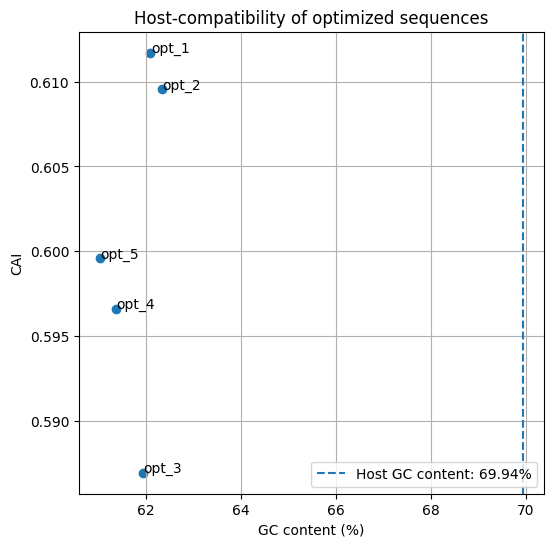

In [11]:
# Section 6: validation of obtained optimized sequences - compatibility with the host species


# Kazusa codon usage table for Streptomyces lividans:
# http://www.kazusa.or.jp/codon/cgi-bin/showcodon.cgi?species=1916

print('CAI (Codon Adaptation Index) is a measurement of the relative adaptiveness of the codon usage of a gene towards the codon usage of highly expressed genes. Its values range from 0 (low) to 1 (high).')

codon_usage = {
    "UUU":0.9, "UUC":24.5, "UUA":0.2, "UUG":3.5,
    "UCU":1.6, "UCC":19.7, "UCA":2.0, "UCG":13.7,
    "UAU":1.2, "UAC":18.9, "UAA":0.3, "UAG":0.6,
    "UGU":1.0, "UGC":8.8, "UGA":2.4, "UGG":15.3,
    "CUU":3.1, "CUC":34.3, "CUA":0.9, "CUG":53.8,
    "CCU":3.4, "CCC":24.8, "CCA":2.5, "CCG":30.1,
    "CAU":2.3, "CAC":19.1, "CAA":2.8, "CAG":32.4,
    "CGU":6.9, "CGC":39.7, "CGA":4.7, "CGG":26.1,
    "AUU":2.0, "AUC":31.4, "AUA":0.9, "AUG":17.2,
    "ACU":2.4, "ACC":37.7, "ACA":3.2, "ACG":19.8,
    "AAU":1.4, "AAC":17.0, "AAA":2.9, "AAG":27.1,
    "AGU":2.3, "AGC":14.6, "AGA":1.1, "AGG":4.0,
    "GUU":2.8, "GUC":42.1, "GUA":3.5, "GUG":28.4,
    "GCU":7.2, "GCC":71.0, "GCA":11.0, "GCG":43.5,
    "GAU":4.7, "GAC":55.5, "GAA":11.8, "GAG":44.6,
    "GGU":9.2, "GGC":55.9, "GGA":7.8, "GGG":14.4,
}
# Convert to DNA
codon_usage_dna = {k.replace("U", "T"): v for k, v in codon_usage.items()}
# Convert raw counts (from Kazusa codon usage table) to relative frequencies
weights = {}
aa_table = {}
for codon, freq in codon_usage_dna.items():
    aa = str(Seq(codon).translate())
    aa_table.setdefault(aa, []).append((codon, freq))
for aa, codons in aa_table.items():
    max_freq = max(freq for codon, freq in codons)
    for codon, freq in codons:
        weights[codon] = freq / max_freq if max_freq > 0 else 0
# Don't know why but the CodonUsage module from Bio.SeqUtils can't be imported...
# We have to define the function to calculate CAI... (and GC content as well,,,)
def cai(seq, weights):
    seq = seq.upper()
    codons = [seq[i:i+3] for i in range(0, len(seq), 3)]
    wi = []
    for codon in codons:
        if codon in weights:
            wi.append(weights[codon])
    if not wi:
        return 0.0
    return math.exp(sum(math.log(w) for w in wi if w > 0) / len(wi))
def gc_fraction(seq):
    seq = seq.upper()
    g = seq.count("G")
    c = seq.count("C")
    total = len(seq)
    return (g + c) / total if total > 0 else 0.0
initial_gc = gc_fraction(initial_seq)
print(f'GC Content of the initial sequence: {initial_gc}')
val_results = []
for i, seq in enumerate(optimized_sequences['best_seq'], start=1):
    seq_diffs = [(j, a, b) for j, (a, b) in enumerate(zip(seq, initial_seq)) if a != b]
    print(f'Substitutions in seq_{i}: {seq_diffs}')
    # Compute CAI
    cai_value = cai(seq, weights)
    # Compute GC content
    gc_content = gc_fraction(Seq(seq)) * 100
    val_results.append({
        'sequence_id': f'opt_{i}',
        'CAI': cai_value,
        'GC_content': gc_content
    })
val_df = pd.DataFrame(val_results)
print(val_df)

# Scatterplot for visualization
plt.figure(figsize=(6, 6))
plt.scatter(val_df['GC_content'], val_df['CAI'])
for _, row in val_df.iterrows():
    plt.text(row['GC_content']+0.01, row['CAI'], row['sequence_id'])
plt.xlabel('GC content (%)')
plt.ylabel('CAI')
host_gc = 69.94
plt.axvline(x=host_gc, linestyle='--', label=f'Host GC content: {host_gc:.2f}%')
plt.title('Host-compatibility of optimized sequences')
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Section 7: structural verification - stability (pLDDT) and alignment with initial sequence via TM-score and PyMol `align`

# Upload initial and optimized protein sequences to ColabFold for PDBs and pLDDT scores
# Upload predicted PDBs to PyMOL

# Use TM-align to calculate TM-scores with the reference (unoptimized) sequence
# https://zhanggroup.org/TM-align/

## Structural predictions

Results given by AlphaFold2, ran via [ColabFold](https://github.com/sokrypton/ColabFold/

**Initial (reference) protein sequence**: pLDDT=94.4, pTM=0.916

![plot0](./img/init_pr.png)

![plot0](./img/init_model3.png)

![plddt0](./img/Optim1_91ca1_plddt.png)

![coverage0](./img/Optim1_91ca1_coverage.png)

Used as reference to align with predicted structures of the following optimized sequences (I only tested two of them): 

**Optimized sequence #1**: pLDDT=94.4, pTM=0.915, RMSD=0.215, TM-score=0.9835

![align1](./img/align_pr1.png)

![plot1](./img/Optim1_model5.png)

![plddt1](./img/Optim1_91ca1_plddt.png)

![coverage1](./img/Optim1_91ca1_coverage.png)

![tm1](./img/tm1.png)


**Optimized sequence #4**: pLDDT=94.6, pTM=0.917, RMSD=0.203, TM-score=0.9801

![align4](./img/align_pr4.png)

![plot4](./img/Optim4_model3.png)

![plddt4](./img/Optim4_7aaf1_0_plddt.png)

![coverage4](./img/Optim4_7aaf1_0_coverage.png)

![tm4](./img/tm4.png)

## Limitations of this computational pipeline

*(just a demo to play around!)*

1. **The greatest one, identified only after running the whole thing - insignificant actual improvement on the metrics.** Sad.

2. Absence of wet-lab validation. The optimized sequence is very likely to fail when synthesized and expressed *in vivo*.

3. Training data is limited to a maximum of only 512 tokens per sequence due to GPU OOMs... (so upsetting). The model now fails to capture long-range dependencies, and its understanding of 'host-likeness' is skewed towards properties of short proteins. However, the full-sequence length of our target alkB gene during inference is much longer...

4. Oversimplification. The optimization relies on a single metric (the generative model's negative log-likelihood), whereas a more robust score should combine multiple measures (CAI, pLDDT, etc). Moreover, the illustration on the active site preservation is way too naive.

5. Hyperparameters might be poorly chosen. This can cause the search in the sequence space to be trapped in local optima, even though the MH-MCMC algorithm (as opposed to a greedy search) is designed to escape them.

---

## Background information about our iGEM project

Our project aims to mitigate plastic pollution by engineering *Streptomyces lividans*, a G+ bacterium abundant in soil, to degrade low-density polyethylene (LDPE). We plan to achieve this by introducing the alkane monooxygenase gene (alkB) from *Rhodococcus erythropolis* and evaluating its efficacy in LDPE breakdown.